# Librerías.

Estas son todas la librerías que vamos a usar en el proceso. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.odr

# Lectura de datos.

Vamos a empezar por convertir el archivo .txt en 2 [dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) de pandas (1 con los datos y otro con las predicciones), eso va a hacer que  su manipulación sea mucho más sencilla. Para eso vamos a usar la función [pandas.read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). Hay que especificar el path al archivo a convertir, en este caso:

*'datos.txt'*

También vamos a combinar la fecha y la hora en una sola columna.

In [2]:
datos = pd.read_csv('datos.txt',delimiter=' ', header = None, 
                names = ['Fecha','Hora','Producción','Velocidad'],skiprows=1,parse_dates=[['Fecha', 'Hora']])

#Crear segundo dataframe con las predicciones (siendo estas las que tienen entrada faltante en 'Producción')
preds = datos[pd.isnull(datos).any(axis=1)]

In [3]:
datos.head()

,Fecha_Hora,Producción,Velocidad
0,2008-01-02 15:00,512.0,36.0
1,2008-01-02 18:00,726.0,27.0
2,2008-01-02 21:00,730.0,23.0
3,2008-01-03 00:00,844.0,38.0
4,2008-01-03 03:00,948.0,46.0


En en el primer dataframe **'datos'** vamos a incluir todos los registros del archivo, luego vamos a asumir que los registros con datos faltantes son las predicciones (NaN values) y con esa condición crear el segundo dataframe **'preds'** y actualizar el primero para dejar fuera las predicciones.

In [4]:
#Actualizamos el dataframe para quitar las predicciones.
datos = datos.dropna()

#Quitamos la primera columna de 'preds' porque no es útil, solo dice 'predicciones'.

preds = preds[preds.Fecha_Hora != 'predicciones nan']

In [5]:
#Dataframe de datos
datos.head()

,Fecha_Hora,Producción,Velocidad
0,2008-01-02 15:00,512.0,36.0
1,2008-01-02 18:00,726.0,27.0
2,2008-01-02 21:00,730.0,23.0
3,2008-01-03 00:00,844.0,38.0
4,2008-01-03 03:00,948.0,46.0


In [6]:
#Dataframe de predicciones
preds.columns = ['Fecha','Velocidad', 'Predicción de producción']
preds.head()

,Fecha,Velocidad,Predicción de producción
2875,2009-11-12 00:00,62.0,NaN
2876,2009-11-15 03:00,65.0,NaN
2877,2009-11-12 06:00,74.0,NaN
2878,2009-11-12 09:00,39.0,NaN
2879,2009-11-16 12:00,26.0,NaN


# Visualización.

Vamos a empezar por un diagrama de dispersión para darnos una idea de la correlación de nuestras variables, en este caso producción y velocidad.

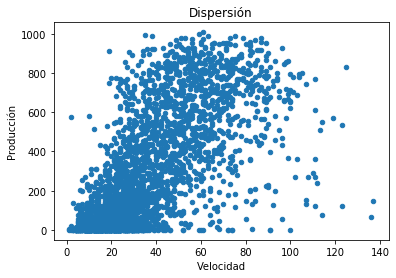

In [7]:
datos.plot.scatter('Velocidad','Producción', title='Dispersión');

Queda claro que hay una relación lineal entre las variables, incluso sin considerar el factor tiempo. Si añadimos este es mucho más evidente.

Vamos a crear un dataframe con índice fecha_hora usando una copia de **'Datos'** para poder hacer una serie temporal.

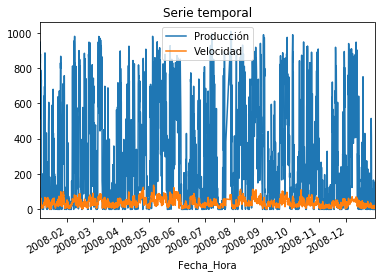

In [8]:
#Copia
datos_indice_hora = datos.copy()
#Ponemos la fecha como indice
datos_indice_hora.set_index('Fecha_Hora', inplace=True)
#transformamos el indice a datetime
datos_indice_hora.index = pd.to_datetime(datos_indice_hora.index)
#hacemos la grafica
datos_indice_hora[['Producción','Velocidad']].plot(title = 'Serie temporal');

En principio no nos deja claro si existe relación en el tiempo, por la diferencia entre los valores de cada variable. Vamos a intentar estandarizarlos para ver si mejora nuestra intuición.

Para esto vamos a usar Sci-kitlearn, en específico la librería de preprocesado de datos. El estandarizador usa la siguiente fórmula:

**x = punto a estandarizar**

**u = promedio**

**s = desviación típica**

**z = (x - u) / s**


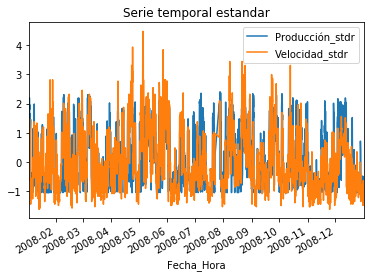

In [9]:
# Creamos el objeto
estandarizador = preprocessing.StandardScaler()
#Le especificamos los datos a transformar y creamos una variable para guardarlos
datos_crudos = estandarizador.fit_transform(datos_indice_hora[['Producción','Velocidad']])
#Creamos un dataframe con la variable 
datos_est = pd.DataFrame(datos_crudos , columns=['Producción_stdr','Velocidad_stdr'],index = datos_indice_hora.index.copy())
#Hacemos la gráfica
datos_est[['Producción_stdr','Velocidad_stdr']].plot(title = 'Serie temporal estandar');

Con ambas variables estandarizadas queda mucho más clara la relación en el tiempo.

## Hipótesis.

Vamos a definir primero nuestra línea, modelo o hipótesis. En este caso es el típico: 
    
    y = mx + b

In [10]:
#Para que sea mas fácil, m y b pasan a ser beta0 y beta1
def hipotesis(beta0,beta1,x):
    '''
    Calcula el valor de una variable dependiente dadas la pendiente y ordenada de un modelo de regresion.
    
    IN:
       beta0: la ordenada de la hipótesis
       beta1: la pendiente de la hipótesis
       x:variable predictora 
    
    OUT:
       predicción 
    
    '''
    return beta0 + (beta1 * x)

# Fórmulas de error.

El ejercicio 1 nos pide implementar 2 fórmulas para calcular el error, empezamos por el porcentaje de error medio absoluto.

In [11]:
#Asumimos que ya tenemos nuestra linea, la pendiente y la ordenada. En este caso para ser rapidos beta0 y beta1
def ema_p(beta0, beta1, X, y):
    ''' Calcula el porcentaje de error medio absoluto entre una serie de observaciones y predicciones.
    
    IN: 
        beta0: la ordenada de la hipotesis
        beta1: la pendiente de la hipotesis
        X:lista de variables predictoras
        y: lista de observaciones o variables dependientes
        
    OUT:
       Porcentaje de error medio absoluto con 2 decimales de precisión.
    
    '''
    ema = 0
    obs = 0

    for (xi,yi) in zip(X,y):
        ema += abs(hipotesis(beta0,beta1,xi) - yi)
        obs += yi
    #Si las suma de las obseraciones es un número muy cerca de 0, regresamos 0
    if obs < 1e-7:
        return 0
    ema_p = (100 / obs) * (ema)
    
    return round(ema_p,2)

Seguimos con el porcentaje de error cuadrado medio:

In [12]:
def ecm_p(beta0, beta1, X, y):
    ''' Calcula el Porcentaje de error cuadrado medio entre una serie de observaciones y predicciones.
    
    IN: 
        beta0: la ordenada de la hipótesis
        beta1: la pendiente de la hipótesis
        X:lista de variables predictoras
        y: lista de observaciones o variables dependientes
        
    OUT:
       Porcentaje de error cuadrado medio con 2 decimales de precisión.'''
    
    ecm = 0
    obs = 0
    
    for (xi,yi) in zip(X,y):
        obs += yi
        ecm += (hipotesis(beta0,beta1,xi) - yi) ** 2 
        
    #Si las suma de las obseraciones es un número muy cerca de 0, regresamos 0
    if obs < 1e-7:
        return 0 
             
    ecm_p = ((100 * len(X))/obs) * (math.sqrt(ecm / len(X)))
    
    return round(ecm_p, 2)

# Modelo base.

Vamos a hacer una regresión lineal normal solo para comparar con los resultados de la regresión de Deming.

In [13]:
#Definimos nuestro objetivo y nuestra variable predictora
X = datos.Velocidad.copy()
y = datos.Producción.copy()

In [14]:
#Vamos a hacer una copia y transformar el formato para que lo acepte scikitlear
X_skt = datos.Velocidad.copy().values.reshape(-1, 1)
y_skt = datos.Producción.copy().values.reshape(-1, 1)

In [15]:
#Creamos un objeto de regresión
reg = LinearRegression()
#Metemos los datos
reg.fit(X_skt, y_skt)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
#Calculamos la ordenada
print(reg.intercept_)
#Y la pendiente
print(reg.coef_)

[-19.05450738]
[[8.73963397]]


In [17]:
def graf_linea(beta0, beta1, X, y,titulox,tituloy):
    '''
    Visualiza la línea y = mx +b de un modelo de regresión lineal en una gráfica de dispersión.
    
    IN:
    beta0: la ordenada de la hipótesis
    beta1: la pendiente de la hipótesis
    X:lista de variables predictoras
    y:lista de observaciones o variables dependientes
    titulox: título del eje x
    titulox: título del eje y
    
    OUT:
    Gráfica de dispersión con linea del modelo en rojo.
    '''
    max_x = np.max(X) 
    min_x = np.min(X) 

    xplot = np.linspace(min_x, max_x, 1000)
    yplot = beta0 + beta1 * xplot
    
    plt.plot(xplot, yplot, color='#ff0000', label='Regression Line')
    plt.xlabel(titulox)
    plt.ylabel(tituloy)

    plt.scatter(X,y,label="Modelo")
    plt.show()

In [18]:
def calificar(beta0,beta1,X,y):
    '''
    Mide el porcentaje de EMA y ECM de un modelo lineal.
    
    IN:
    beta0: la ordenada de la hipótesis
    beta1: la pendiente de la hipótesis
    X:lista de variables predictoras
    y: lista de observaciones o variables dependientes

    OUT:
    % de ECM y % de EMA con 2 decimales de precisión
    '''
    return ecm_p(beta0, beta1, X, y), ema_p(beta0, beta1, X, y)  

Vamos a graficar y calificar nuestro modelo básico de regresión lineal.

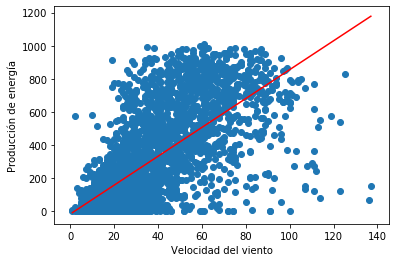

El % de ECM y EMA es: (71.3, 54.91)


In [19]:
graf_linea( -19.05450738,8.73963397, X, y,'Velocidad del viento','Producción de energía')
print(f'El % de ECM y EMA es: {calificar( -19.05450738,8.73963397, X, y)}')

# Regresión de Deming.

Ahora vamos a implementar una función que tome un dataframe de pandas, 'x' e 'y' especificando las columnas con las cuales hacer la regresión, el valor de delta y regrese la pendiente y la ordenada de un modelo lineal.

In [20]:
def deming_regresion(datos, X, y, delta = 1):
    '''
    Calcula la pendiente y ordenada de un modelo lineal usando la regresión de Deming.
    
    IN:
    
    datos:DataFrame de pandas con los datos para la regresión
    X: string de la variable predictora como aparece en nuestro dataframe
    y: string del objetivo o varible dependiente como aparece en nuestro dataframe
    delta: proporción entre la varianza del error en X y el error en y, esta en 1 por defecto
    
    OUT: 
    ordenada: ordenada de nuestro modelo lineal
    pendiente: pendiente del modelo lineal
    
    '''
    
    cov = datos.cov()
    media_x = datos[X].mean()
    media_y = datos[y].mean()
    s_xx = cov[X][X]
    s_yy = cov[y][y]
    s_xy = cov[X][y]
    
    pendiente = (s_yy  - delta * s_xx + np.sqrt((s_yy - delta * s_xx) ** 2 + 4 * delta * s_xy ** 2)) / (2 * s_xy)
    ordenada = media_y - pendiente  * media_x
               
    return ordenada, pendiente

Calculamos nuestra pendiente y varible con la función de arriba, para graficar y calificar el modelo.


In [21]:
ordenada, pendiente = deming_regresion(datos, 'Velocidad', 'Producción')

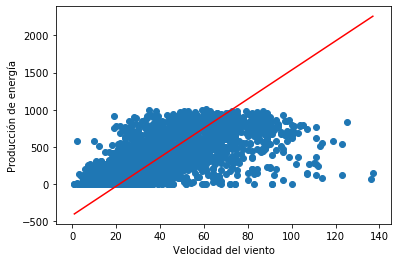

El % de ECM y EMA es: (106.44, 77.15)


In [22]:
graf_linea( ordenada, pendiente, X, y,'Velocidad del viento','Producción de energía')
print(f'El % de ECM y EMA es: {calificar( ordenada, pendiente, X, y)}')

# Error de ajuste por mes.

Vamos a crear un dataframe con columnas que lleven el mes y el año de cada punto de datos, para agrupar el %ECM y %EMA por mes y año.

In [23]:
#Dataframe de error
error = datos.copy()

In [24]:
#Transformamos la fecha y hora a dtype datetime
error['Fecha_Hora'] = pd.to_datetime(error['Fecha_Hora'])

In [25]:
#Sacamos el año y mes de Fecha_Hora para que cada entrada de datos tenga la columna con dicha información
error['año'] = pd.DatetimeIndex(error.Fecha_Hora).year
error['mes'] = pd.DatetimeIndex(error.Fecha_Hora).month

In [26]:
#Aplicamos nuestras funciones de error por mes y año y guardamos el resultado en una variable para poder acceder a ello después
ecmxmes = error.groupby((error.mes, error.año)).apply(lambda row: ecm_p(ordenada, pendiente, row['Velocidad'], row['Producción']))

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


In [27]:
ecmxmes

mes  año 
1    2008    129.57
2    2008     90.67
3    2008     90.86
4    2008    145.13
5    2008    103.27
6    2008    135.57
7    2008     95.99
8    2008     95.49
9    2008     79.49
10   2008     88.43
11   2008    139.79
12   2008     82.17
dtype: float64

In [28]:
#Hacemos lo mismo con el error absoluto
emaxmes = error.groupby((error.mes, error.año)).apply(lambda row: ema_p(ordenada, pendiente, row['Velocidad'], row['Producción']))

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


In [29]:
emaxmes

mes  año 
1    2008     94.24
2    2008     71.27
3    2008     73.17
4    2008     99.62
5    2008     73.11
6    2008    106.69
7    2008     72.66
8    2008     65.42
9    2008     60.31
10   2008     67.38
11   2008    113.65
12   2008     67.45
dtype: float64

# Regresión Ortogonal. 

En wikipedia podemos ver que cuando delta = 1 nuestra regresión de Deming hace lo mismo que una regresión ortogonal. Así que vamos a ver si eso nos da mejores resultados.

## Usando scipy para hacer la regresión ortogonal.

In [30]:
#Definimos la función de nuestra línea
def f(B, x):
    '''Función lineal y = mx + b
    
    Scipy pasa Beta como una lista por eso usamos los indices en la función.'''
    return B[0]*x + B[1]

In [31]:
#Pasamos la función al modelo de scipy
linear = scipy.odr.Model(f)

In [32]:
#Pasamos los datos y la desviación estándar de cada variable
mydata =  scipy.odr.RealData(X, y, sx=datos.cov()['Velocidad']['Velocidad'], sy=datos.cov()['Producción']['Producción'])

In [33]:
#Pasamos todo al modelo ortogonal
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])

In [34]:
#hacemos los cálculos
myoutput = myodr.run()

In [35]:
#imprimimos resultados
myoutput.beta

array([  8.76792215, -20.10501376])

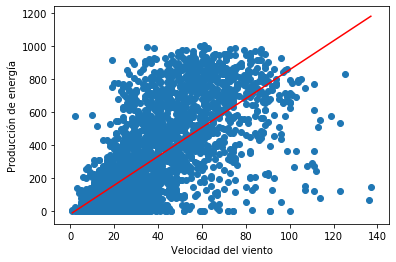

El % de ECM y EMA es: (71.3, 54.86)


In [36]:
graf_linea(-20.10501376279761, 8.76792215427729, X, y,'Velocidad del viento','Producción de energía')
print(f'El % de ECM y EMA es: {calificar(-20.10501376279761, 8.76792215427729, X, y)}')

# Predicciones.

Vamos a predecir usando nuestra hipótesis ortogonal.

In [37]:
preds['Predicción de producción'] = preds['Velocidad'].apply(lambda x: hipotesis(-20.10501376279761, 8.76792215427729,x))

In [38]:
preds.head()

,Fecha,Velocidad,Predicción de producción
2875,2009-11-12 00:00,62.0,523.506160
2876,2009-11-15 03:00,65.0,549.809926
2877,2009-11-12 06:00,74.0,628.721226
2878,2009-11-12 09:00,39.0,321.843950
2879,2009-11-16 12:00,26.0,207.860962


# Conclusión.

La regresión ortogonal da ligeros mejores resultados si la comparamos con en el modelo base, pero infinitamente mejores que la regresión de Deming, así que dado que podemos asumir delta = 1, voy a hacer la implementación usando scipy.

# Extra.

Es curioso cómo cuando tratamos de predecir el viento usando la producción energética como variable predictora, obtenemos mejores resultados y parece haber una relación lineal aún mas obvia. Aquí dejo una gráfica y una calificación del modelo X = Producción y = Velocidad.

In [39]:
ordenada1, pendiente1 = deming_regresion(datos, 'Producción', 'Velocidad')

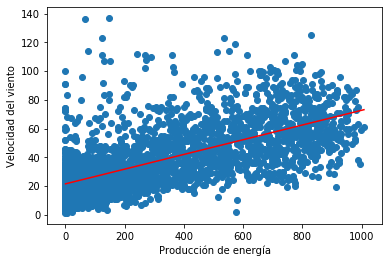

El % de ECM y EMA es: (44.82, 32.49)


In [40]:
graf_linea( ordenada1, pendiente1, y, X,'Producción de energía','Velocidad del viento')
print(f'El % de ECM y EMA es: {calificar(ordenada1, pendiente1, y, X)}')